In [571]:
# Importing dependencies

In [572]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import xgboost as xgb
from sklearn.metrics import mean_squared_error
color_pal = sns.color_palette()
plt.style.use('fivethirtyeight')

In [573]:
fpn = pd.read_csv("wfp_food_prices_nga.csv", skiprows=[1])
fpn

,date,admin1,admin2,market,latitude,longitude,category,commodity,unit,priceflag,pricetype,currency,price,usdprice
0,2002-01-15,Katsina,Jibia,Jibia (CBM),13.080000,7.240000,cereals and tubers,Maize,KG,actual,Wholesale,NGN,175.92,1.5525
1,2002-01-15,Katsina,Jibia,Jibia (CBM),13.080000,7.240000,cereals and tubers,Millet,KG,actual,Wholesale,NGN,150.18,1.3254
2,2002-01-15,Katsina,Jibia,Jibia (CBM),13.080000,7.240000,cereals and tubers,Rice (imported),KG,actual,Wholesale,NGN,358.70,3.1656
3,2002-01-15,Katsina,Jibia,Jibia (CBM),13.080000,7.240000,cereals and tubers,Sorghum,KG,actual,Wholesale,NGN,155.61,1.3733
4,2002-01-15,Katsina,Jibia,Jibia (CBM),13.080000,7.240000,pulses and nuts,Beans (niebe),KG,actual,Wholesale,NGN,196.87,1.7374
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
73685,2023-12-15,Yobe,Yusufari,Yusufari,13.062665,11.171371,vegetables and fruits,Onions,0.5 KG,aggregate,Retail,NGN,200.00,0.2530
73686,2023-12-15,Yobe,Yusufari,Yusufari,13.062665,11.171371,vegetables and fruits,Oranges,400 G,aggregate,Retail,NGN,200.00,0.2530
73687,2023-12-15,Yobe,Yusufari,Yusufari,13.062665,11.171371,vegetables and fruits,Spinach,300 G,aggregate,Retail,NGN,50.00,0.0633
73688,2023-12-15,Yobe,Yusufari,Yusufari,13.062665,11.171371,vegetables and fruits,Tomatoes,0.5 KG,aggregate,Retail,NGN,200.00,0.2530


In [574]:
fpn.describe()

,latitude,longitude,price,usdprice
count,73690.000000,73690.000000,73690.000000,73690.000000
mean,11.446065,10.490864,5424.801839,16.378580
std,1.634753,2.915867,10971.943319,31.462483
min,5.147640,3.401897,1.000000,0.002300
25%,11.280160,8.429120,200.000000,0.602000
50%,11.831100,11.499503,483.055000,1.324800
75%,12.362300,13.141492,3504.837500,16.389000
max,13.645000,13.913103,138000.000000,456.922400


In [575]:
# Checks for NaN or null values and returns the column they were found in

columns_with_null = fpn.columns[fpn.isna().any()].tolist()

if len(columns_with_null) > 0:
    print("The following columns have NaN or null values:")
    print(columns_with_null)
else:
    print("No columns have NaN or null values.")

No columns have NaN or null values.


In [576]:
# Converting the date column fron object to datetime to enable time series analysis
fpn["date"] = pd.to_datetime(fpn["date"])

In [577]:
fpn.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 73690 entries, 0 to 73689
Data columns (total 14 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   date       73690 non-null  datetime64[ns]
 1   admin1     73690 non-null  object        
 2   admin2     73690 non-null  object        
 3   market     73690 non-null  object        
 4   latitude   73690 non-null  float64       
 5   longitude  73690 non-null  float64       
 6   category   73690 non-null  object        
 7   commodity  73690 non-null  object        
 8   unit       73690 non-null  object        
 9   priceflag  73690 non-null  object        
 10  pricetype  73690 non-null  object        
 11  currency   73690 non-null  object        
 12  price      73690 non-null  float64       
 13  usdprice   73690 non-null  float64       
dtypes: datetime64[ns](1), float64(4), object(9)
memory usage: 7.9+ MB


In [578]:
# From the output fpn table above, it seems like when the "priceflag" is "actual", the corresponding unit is "KG". This can be useful in standardizing all 
# values in our "unit" column to 1 KG or "KG" in relation to the price. This code is confirming this inference

In [579]:
fpn[fpn["priceflag"] == "actual"]["unit"].unique()

array(['KG', '100 KG', '50 KG', 'Unit', 'L', '100 L', '1.3 KG', '1.4 KG',
       '3.4 KG', '20 G', '750 ML', '1.1 KG', '0.5 KG', '1.5 KG', '30 pcs',
       '400 G', '300 G', '2.1 KG', '3.1 KG', '1.2 KG', '250 G',
       '100 Tubers'], dtype=object)

In [580]:
fpn[fpn["priceflag"] == "aggregate"]["unit"].unique()

array(['2.5 KG', '30 pcs', 'KG', '20 G', '500 G', 'L', '1.3 KG', '0.5 KG',
       '400 G', '300 G', '2.1 KG', 'Unit', '100 KG', '50 KG',
       '100 Tubers', '1.2 KG'], dtype=object)

In [581]:
fpn[fpn["unit"] == "30 pcs"]["commodity"].unique()

array(['Eggs'], dtype=object)

In [582]:
(fpn["unit"] == "30 pcs").sum()

1442

In [583]:
fpn[fpn["unit"] == "Unit"]["commodity"].unique()

array(['Bread'], dtype=object)

In [584]:
(fpn["unit"] == "Unit").sum()

1457

In [585]:
fpn[fpn["unit"] == "100 Tubers"]["commodity"].unique()

array(['Yam', 'Yam (Abuja)'], dtype=object)

In [586]:
(fpn["unit"] == "100 Tubers").sum()

472

In [587]:
fpn[fpn["unit"].str.contains("L")]["commodity"].unique()

array(['Fuel (diesel)', 'Fuel (petrol-gasoline)', 'Oil (palm)',
       'Oil (vegetable)'], dtype=object)

In [588]:
# So we've found out that where the units 30pcs - the corresponding commodity was eggs, where it was "Unit" -  "Bread"
# and where it was "100 Tubers" - ['Yam', 'Yam (Abuja)']. 


# We also found out commodities that were in litres because they are liquid. Two of these - ['Fuel (diesel)', 'Fuel (petrol-gasoline)'] aren't food
# commodities and we'd be dropping them later on.


# For uniformity in analysis, we'd be converting these commodities to their corresponding masses in KG. We're are referencing Google for the average weight
# of these commodities.

In [589]:
fpn.unit.unique()

array(['KG', '100 KG', '50 KG', 'Unit', 'L', '100 L', '1.3 KG', '1.4 KG',
       '3.4 KG', '20 G', '750 ML', '1.1 KG', '0.5 KG', '1.5 KG', '30 pcs',
       '400 G', '300 G', '2.1 KG', '3.1 KG', '1.2 KG', '250 G',
       '100 Tubers', '2.5 KG', '500 G'], dtype=object)

In [590]:
fpn.sample(15)

,date,admin1,admin2,market,latitude,longitude,category,commodity,unit,priceflag,pricetype,currency,price,usdprice
50484,2023-02-15,Yobe,Borsari,Bursari,12.496693,11.499503,pulses and nuts,Cowpeas,1.2 KG,actual,Retail,NGN,429.00,0.9325
3194,2014-09-15,Kano,Dawakin Tofa,Dawanau,12.090120,8.429120,cereals and tubers,Yam,100 KG,actual,Wholesale,NGN,26400.00,164.8969
41810,2020-11-15,Yobe,Nguru,Nguru,12.872965,10.445595,vegetables and fruits,Onions,400 G,actual,Retail,NGN,155.00,0.4068
60682,2022-01-15,Kaduna,Giwa,Giwa,11.280160,7.417860,oil and fats,Oil (palm),L,aggregate,Retail,NGN,720.00,1.6986
61035,2022-02-15,Borno,Biu,Biu,10.611100,12.195000,pulses and nuts,Cowpeas (brown),100 KG,aggregate,Wholesale,NGN,40600.00,97.7748
65146,2022-10-15,Zamfara,Kaura Namoda,Kaura Namoda,12.595190,6.586350,non-food,Fuel (diesel),L,aggregate,Retail,NGN,844.52,1.9283
15685,2017-07-15,Yobe,Damaturu,Damaturu,11.744440,11.961110,cereals and tubers,Sorghum (brown),100 KG,actual,Wholesale,NGN,13650.00,44.6401
2167,2013-06-15,Katsina,Jibia,Jibia (CBM),13.080000,7.240000,cereals and tubers,Millet,KG,actual,Wholesale,NGN,261.74,1.6639
18313,2017-11-15,Yobe,Damaturu,Damaturu (Sunday Market),11.739766,11.955811,pulses and nuts,Groundnuts,1.2 KG,actual,Retail,NGN,800.00,2.2472
23794,2018-07-15,Yobe,Jakusko,Jakusko,12.201859,10.878244,pulses and nuts,Beans (white),1.2 KG,actual,Retail,NGN,400.00,1.3079


In [591]:
fpn[~fpn["unit"].str.contains(" ")]["unit"].unique()

array(['KG', 'Unit', 'L'], dtype=object)

In [592]:
# Standardizing the unit column with the price column so that the weight of all the commodities are unit KG and the prices are modified to be per kG of that commodity

In [593]:
def standardize_30pcs(df):
    for index, row in df.iterrows():
        unit = row['unit']
        if unit == "30 pcs":
            # On average, a medium-sized chicken egg weighs approximately 49.6 grams or 1.75 ounces. Now, let’s calculate the weight of 30 eggs:
            #Weight of one egg (medium): 49.6 grams
            #Weight of 30 eggs: (30 \times 49.6 , \text{grams} = 1488 , \text{grams})
            #Therefore, 30 medium-sized eggs weigh approximately 1488 grams or approximately 1.49 kilograms. That’s a lot of eggs!
            val, st = unit.split(" ")
            val = float(val)
            df.at[index, "unit"] = f"{round(float(val) * 0.0496, 2)} KG"

In [594]:
standardize_30pcs(fpn)
fpn.sample(5)

,date,admin1,admin2,market,latitude,longitude,category,commodity,unit,priceflag,pricetype,currency,price,usdprice
6128,2015-09-15,Gombe,Akko,Gombe,10.283330,11.166670,pulses and nuts,Cowpeas (white),100 KG,actual,Wholesale,NGN,11500.00,57.8035
39825,2020-07-15,Borno,Maiduguri,Monday,11.834551,13.152417,cereals and tubers,Sorghum,1.4 KG,actual,Retail,NGN,160.00,0.4140
34257,2019-10-15,Adamawa,Hong,Mubi,10.267610,13.264360,cereals and tubers,Yam,KG,actual,Retail,NGN,497.70,1.3902
59404,2021-08-15,Kebbi,Gwandu,Gwandu,12.493820,4.642270,cereals and tubers,Rice (local),KG,aggregate,Retail,NGN,364.52,0.8885
48098,2021-12-15,Yobe,Karasuwa,Bade (Gashua),12.868665,11.039624,cereals and tubers,Sorghum,1.3 KG,actual,Retail,NGN,200.00,0.4884


In [595]:
def standardize_unit(df):
    for index, row in df.iterrows():
        unit = row['unit']
        if unit == "Unit":
            # A typical white or whole wheat bread loaf may weigh between 16-24 ounces (450-680 grams).
            # We'd assume the weight to be the average of these values - 20 ounces(567g/0.567KG)
            df.at[index, "unit"] = f"{0.567} KG"

In [596]:
standardize_unit(fpn)
fpn.sample(5)

,date,admin1,admin2,market,latitude,longitude,category,commodity,unit,priceflag,pricetype,currency,price,usdprice
5372,2015-06-15,Gombe,Akko,Gombe,10.283330,11.166670,pulses and nuts,Cowpeas (brown),100 KG,actual,Wholesale,NGN,14250.00,71.6440
16970,2017-09-15,Yobe,Geidam,Geidam,12.890278,11.921166,oil and fats,Oil (palm),750 ML,actual,Retail,NGN,700.00,2.0000
40489,2020-08-15,Yobe,Yusufari,Yusufari,13.062665,11.171371,oil and fats,Oil (palm),750 ML,actual,Retail,NGN,400.00,1.0499
25577,2018-10-15,Borno,Maiduguri,Maiduguri,11.831100,13.150970,cereals and tubers,Rice (imported),50 KG,actual,Wholesale,NGN,16600.32,45.7940
51425,2023-06-15,Borno,Maiduguri,Monday,11.834551,13.152417,cereals and tubers,Sorghum,1.4 KG,actual,Retail,NGN,432.00,0.6646


In [597]:
def standardize_100tubers(df):
    for index, row in df.iterrows():
        unit = row['unit']
        if unit == "100 Tubers":
            # In terms of weight, cultivated yam tubers can vary significantly, but on average, they weigh between 5 to 10 kilograms. 
            # Let’s consider the lower end of this range for our calculation.
            # Assuming we take a conservative estimate of 5 kilograms per yam tuber, we can determine how many tubers would amount to 1 kilogram:
            val, st = unit.split(" ")
            val = float(val)
            df.at[index, "unit"] = f"{round(float(val) * 5, 2)} KG"

In [598]:
standardize_100tubers(fpn)
fpn.sample(20)

,date,admin1,admin2,market,latitude,longitude,category,commodity,unit,priceflag,pricetype,currency,price,usdprice
19598,2018-01-15,Lagos,Kosofe,Lagos,6.612164,3.401897,cereals and tubers,Millet,KG,actual,Retail,NGN,214.00,0.5978
10415,2016-10-15,Jigawa,Kaugama,Gujungu,12.362300,9.583600,pulses and nuts,Groundnuts (shelled),100 KG,actual,Wholesale,NGN,26000.00,85.2099
34230,2019-09-15,Zamfara,Kaura Namoda,Kaura Namoda,12.595190,6.586350,non-food,Fuel (petrol-gasoline),L,actual,Retail,NGN,144.05,0.4692
19531,2018-01-15,Kaduna,Lere,Saminaka,10.416500,8.681380,oil and fats,Oil (palm),L,actual,Retail,NGN,533.33,1.4898
44129,2021-05-15,Borno,Maiduguri,Tashan Bama,11.810953,13.182150,oil and fats,Oil (vegetable),750 ML,actual,Retail,NGN,633.00,1.6009
60507,2022-01-15,Abia,Oboma Ngwa,Aba,5.147640,7.356720,cereals and tubers,Yam,500.0 KG,aggregate,Wholesale,NGN,80000.00,188.7367
41869,2020-11-15,Yobe,Yusufari,Yusufari,13.062665,11.171371,"meat, fish and eggs",Eggs,1.49 KG,actual,Retail,NGN,1200.00,3.1496
48965,2022-02-15,Yobe,Gulani,Gulani (Tettaba),10.813902,11.728192,vegetables and fruits,Spinach,300 G,actual,Retail,NGN,30.00,0.0722
55282,2020-11-15,Kano,Dawakin Tofa,Dawanau,12.090120,8.429120,cereals and tubers,"Cassava meal (gari, yellow)",100 KG,aggregate,Wholesale,NGN,21270.67,55.8285
48255,2021-12-15,Zamfara,Kaura Namoda,Kaura Namoda,12.595190,6.586350,cereals and tubers,Maize (yellow),KG,actual,Retail,NGN,203.52,0.4970


In [599]:
def standardize_KG_G(df):
    for index, row in df.iterrows():
        unit = row['unit']
        if unit == "KG":
            df.at[index, "unit"] = "1 KG"
        elif " " in unit:
            val, st = unit.split(" ")
            if st == "KG":
                df.at[index, "unit"] = unit
            elif st == "G":
                df.at[index, "unit"] = f"{round(float(val) / 1000, 2)} KG"

In [600]:
standardize_KG_G(fpn)
fpn.sample(20)

,date,admin1,admin2,market,latitude,longitude,category,commodity,unit,priceflag,pricetype,currency,price,usdprice
7001,2015-12-15,Kaduna,Lere,Saminaka,10.416500,8.681380,cereals and tubers,Sorghum (brown),100 KG,actual,Wholesale,NGN,4160.00,21.2353
64978,2022-10-15,Kebbi,Gwandu,Gwandu,12.493820,4.642270,cereals and tubers,Bread,0.567 KG,aggregate,Retail,NGN,215.16,0.4913
36182,2019-12-15,Kano,Dawakin Tofa,Dawanau,12.090120,8.429120,cereals and tubers,Sorghum (brown),100 KG,actual,Wholesale,NGN,8072.50,26.2948
23759,2018-07-15,Yobe,Gulani,Gulani (Tettaba),10.813902,11.728192,"meat, fish and eggs",Eggs,1.49 KG,actual,Retail,NGN,1000.00,3.2699
61296,2022-02-15,Lagos,Kosofe,Lagos,6.612164,3.401897,pulses and nuts,Groundnuts (shelled),1 KG,aggregate,Retail,NGN,786.10,1.8931
55385,2020-11-15,Lagos,Kosofe,Lagos,6.612164,3.401897,cereals and tubers,Sorghum (white),100 KG,aggregate,Wholesale,NGN,22283.33,58.4864
15348,2017-07-15,Borno,Konduga,Baga Road,11.867950,13.123314,vegetables and fruits,Onions,0.5 KG,actual,Retail,NGN,95.00,0.3107
73089,2023-12-15,Borno,Damboa,Damboa,11.157588,12.759812,oil and fats,Oil (vegetable),L,aggregate,Retail,NGN,1130.00,1.4295
25856,2018-10-15,Yobe,Geidam,Geidam,12.890278,11.921166,cereals and tubers,Sorghum,1.3 KG,actual,Retail,NGN,150.00,0.4138
15790,2017-07-15,Yobe,Nguru,Nguru,12.872965,10.445595,cereals and tubers,Sorghum,1.3 KG,actual,Retail,NGN,375.00,1.2264


In [601]:
def standardize_L_ML(df):
    for index, row in df.iterrows():
        unit = row['unit']
        commodity = row["commodity"]
        if "L" in unit:
            if unit == "L":
                if commodity == "Oil (palm)":
                    # 1 liter of palm oil weighs approximately 912.98 grams or 0.91 kilograms
                    # Please note that this estimation is based on the density of palm oil and serves as a good comparison.
                    df.at[index, "unit"] = "0.91 KG"
                elif commodity == "Oil (vegetable)":
                    # The density of vegetable oil varies depending on the type of oil. 
                    # On average, 1 kg of oil equals 1.09 liters. Therefore, 1 liter of vegetable oil weighs approximately 0.92 kg.
                    df.at[index, "unit"] = "0.92 KG"
                else:
                    pass
            else:
                if " " in unit:
                    val, st = unit.split(" ")
                    if st == "L":
                        if commodity == "Oil (palm)":
                            df.at[index, "unit"] = f"{round((float(val) * 0.91))} KG"
                        elif commodity == "Oil (vegetable)":
                            df.at[index, "unit"] = f"{round((float(val) * 0.92))} KG"
                    elif st == "ML":
                        if commodity == "Oil (palm)":
                            df.at[index, "unit"] = f"{round((float(val) / 1000) * 0.91)} KG"
                        elif commodity == "Oil (vegetable)":
                            df.at[index, "unit"] = f"{round((float(val) / 1000) * 0.92)} KG"

In [602]:
standardize_L_ML(fpn)
fpn.sample(20)

,date,admin1,admin2,market,latitude,longitude,category,commodity,unit,priceflag,pricetype,currency,price,usdprice
44015,2021-05-15,Borno,Maiduguri,Budum,11.849734,13.163442,cereals and tubers,Maize flour,1.3 KG,actual,Retail,NGN,198.00,0.5008
63066,2022-06-15,Kaduna,Lere,Saminaka,10.416500,8.681380,pulses and nuts,Groundnuts (shelled),1 KG,aggregate,Retail,NGN,875.00,2.0883
62741,2022-05-15,Yobe,Damaturu,Damaturu,11.744440,11.961110,cereals and tubers,Sorghum (white),1 KG,aggregate,Retail,NGN,204.57,0.4918
23352,2018-07-15,Borno,Maiduguri,Budum,11.849734,13.163442,cereals and tubers,Millet,1.4 KG,actual,Retail,NGN,150.00,0.4905
52437,2020-04-15,Yobe,Damaturu,Damaturu,11.744440,11.961110,pulses and nuts,Cowpeas (white),100 KG,aggregate,Wholesale,NGN,11356.67,29.4978
33489,2019-09-15,Borno,Konduga,Bullunkutu,11.829812,13.092646,vegetables and fruits,Oranges,0.4 KG,actual,Retail,NGN,50.00,0.1629
60855,2022-01-15,Oyo,Ibadan North,Ibadan,7.401960,3.917310,non-food,Fuel (diesel),L,aggregate,Retail,NGN,412.00,0.9720
31787,2019-06-15,Yobe,Nguru,Nguru,12.872965,10.445595,vegetables and fruits,Bananas,1.3 KG,actual,Retail,NGN,120.00,0.3910
41375,2020-10-15,Yobe,Potiskum,Potiskum,11.707240,11.082490,vegetables and fruits,Spinach,0.3 KG,actual,Retail,NGN,100.00,0.2628
20467,2018-02-15,Yobe,Gulani,Gulani (Tettaba),10.813902,11.728192,pulses and nuts,Groundnuts,1.2 KG,actual,Retail,NGN,600.00,1.6807


In [603]:
fpn[~fpn["unit"].str.contains("KG")]["commodity"].unique()

array(['Fuel (diesel)', 'Fuel (petrol-gasoline)'], dtype=object)

In [604]:
# We've successfully standardized prices excluding non-food commodities['Fuel (diesel)', 'Fuel (petrol-gasoline)']

In [605]:
def standardize_price(df):
    for index, row in df.iterrows():
        unit = row['unit']
        price = row["price"]
        if "KG" in unit:
            if " " in unit:
                val, ut = unit.split(" ")
                val = float(val)
                df.at[index, "price"] = price / val
                df.at[index, "unit"] = "KG"
            else:
                df.at[index, "price"] = price  # No conversion needed

In [606]:
standardize_price(fpn)
fpn.sample(20)

,date,admin1,admin2,market,latitude,longitude,category,commodity,unit,priceflag,pricetype,currency,price,usdprice
26520,2018-11-15,Yobe,Borsari,Bursari,12.496693,11.499503,pulses and nuts,Beans (white),KG,actual,Retail,NGN,275.000000,0.9066
37145,2020-01-15,Yobe,Damaturu,Damaturu,11.744440,11.961110,cereals and tubers,Maize (yellow),KG,actual,Retail,NGN,90.630000,0.2517
45653,2021-08-15,Yobe,Yusufari,Yusufari,13.062665,11.171371,cereals and tubers,Yam,KG,actual,Retail,NGN,290.322581,2.1938
45,2002-06-15,Katsina,Jibia,Jibia (CBM),13.080000,7.240000,cereals and tubers,Millet,KG,actual,Wholesale,NGN,216.970000,1.8395
47426,2021-12-15,Adamawa,Hong,Mubi,10.267610,13.264360,cereals and tubers,"Cassava meal (gari, yellow)",KG,actual,Wholesale,NGN,180.000000,43.9593
34075,2019-09-15,Yobe,Jakusko,Jakusko,12.201859,10.878244,vegetables and fruits,Oranges,KG,actual,Retail,NGN,125.000000,0.1629
21200,2018-03-15,Yobe,Karasuwa,Bade (Gashua),12.868665,11.039624,"meat, fish and eggs",Meat (beef),KG,actual,Retail,NGN,1000.000000,2.8011
21562,2018-04-15,Borno,Maiduguri,Tashan Bama,11.810953,13.182150,cereals and tubers,Maize flour,KG,actual,Retail,NGN,211.538462,0.8996
70826,2023-08-15,Borno,Maiduguri,Tashan Bama,11.810953,13.182150,cereals and tubers,Maize flour,KG,aggregate,Retail,NGN,400.000000,1.3057
42742,2021-01-15,Yobe,Potiskum,Potiskum,11.707240,11.082490,"meat, fish and eggs",Fish,KG,actual,Retail,NGN,125.000000,0.4000


In [607]:
# We've successfully standardized units and prices. We'd now filter out columns that we'd not be using as features and non-food rows

In [608]:
# Dropping non-food rows

In [609]:
cols_to_drop = ["unit", "priceflag", "pricetype", "currency", "usdprice"]
fpn = fpn.drop(cols_to_drop, axis=1)

In [610]:
fpn.to_csv('raw_data.csv', index=False)

In [554]:
data = fpn[fpn.commodity == 'Oranges']
data = data[["date","price"]]
data

,date,price
9399,2016-08-15,333.250
9417,2016-08-15,250.000
9436,2016-08-15,266.750
9454,2016-08-15,125.000
9473,2016-08-15,266.750
...,...,...
73587,2023-12-15,354.175
73612,2023-12-15,293.750
73637,2023-12-15,723.950
73661,2023-12-15,500.000


In [555]:
data = data.groupby('date').price.mean().reset_index()
data

,date,price
0,2013-12-15,250.000000
1,2014-01-15,250.000000
2,2015-01-15,250.000000
3,2016-01-15,250.000000
4,2016-08-15,241.666667
...,...,...
84,2023-08-15,372.667708
85,2023-09-15,408.132692
86,2023-10-15,423.821429
87,2023-11-15,440.624107


In [556]:
data['date'] = pd.to_datetime(data['date'])

# Sort by date
data.sort_values(by='date', inplace=True)
data

,date,price
0,2013-12-15,250.000000
1,2014-01-15,250.000000
2,2015-01-15,250.000000
3,2016-01-15,250.000000
4,2016-08-15,241.666667
...,...,...
84,2023-08-15,372.667708
85,2023-09-15,408.132692
86,2023-10-15,423.821429
87,2023-11-15,440.624107


In [557]:
data = data.set_index('date')
data

,price
date,
2013-12-15,250.000000
2014-01-15,250.000000
2015-01-15,250.000000
2016-01-15,250.000000
2016-08-15,241.666667
...,...
2023-08-15,372.667708
2023-09-15,408.132692
2023-10-15,423.821429


In [558]:
df=data.copy()

df

,price
date,
2013-12-15,250.000000
2014-01-15,250.000000
2015-01-15,250.000000
2016-01-15,250.000000
2016-08-15,241.666667
...,...
2023-08-15,372.667708
2023-09-15,408.132692
2023-10-15,423.821429


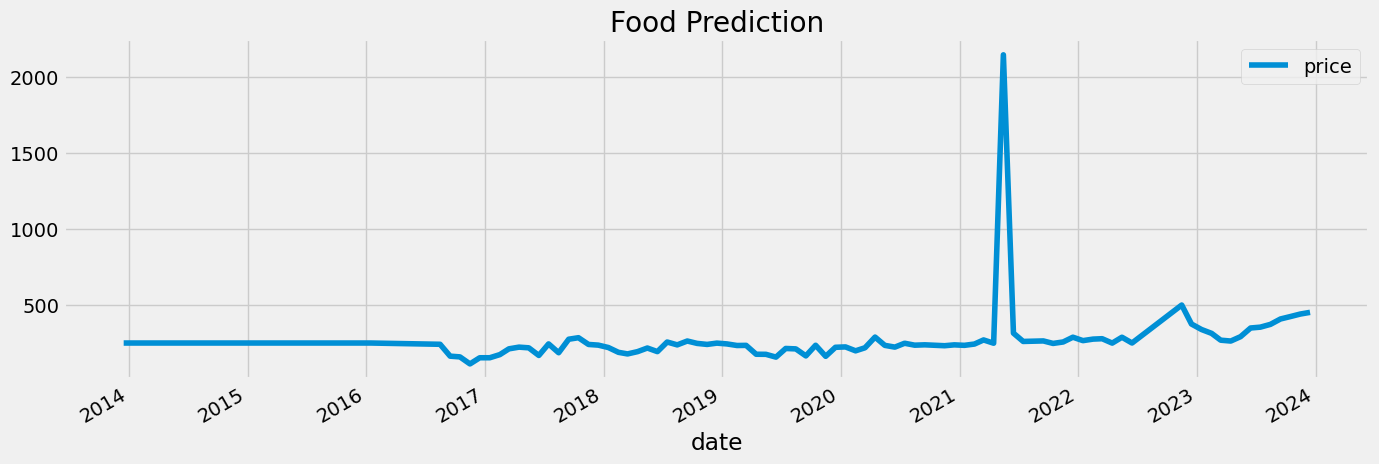

In [559]:
df.plot(
        figsize=(15, 5),
        title='Food Prediction')
plt.show()


In [ ]:
train = df.loc[df.index < '01-01-2022']
test = df.loc[df.index >= '01-01-2022']

fig, ax = plt.subplots(figsize=(15, 5))
train.plot(ax=ax, label='Training Set', title='Data Train/Test Split')
test.plot(ax=ax, label='Test Set')
ax.axvline('01-01-2020', color='black', ls='--')
ax.legend(['Training Set', 'Test Set'])
plt.show()

In [560]:
def create_features(df):
    """
    Create time series features based on time series index.
    """
    df = df.copy()
    df['quarter'] = df.index.quarter
    df['month'] = df.index.month
    df['year'] = df.index.year
    df['dayofyear'] = df.index.dayofyear
    df['dayofmonth'] = df.index.day
    df['weekofyear'] = df.index.isocalendar().week
    return df

df = create_features(df)
df

,price,quarter,month,year,dayofyear,dayofmonth,weekofyear
date,,,,,,,
2013-12-15,250.000000,4,12,2013,349,15,50
2014-01-15,250.000000,1,1,2014,15,15,3
2015-01-15,250.000000,1,1,2015,15,15,3
2016-01-15,250.000000,1,1,2016,15,15,2
2016-08-15,241.666667,3,8,2016,228,15,33
...,...,...,...,...,...,...,...
2023-08-15,372.667708,3,8,2023,227,15,33
2023-09-15,408.132692,3,9,2023,258,15,37
2023-10-15,423.821429,4,10,2023,288,15,41


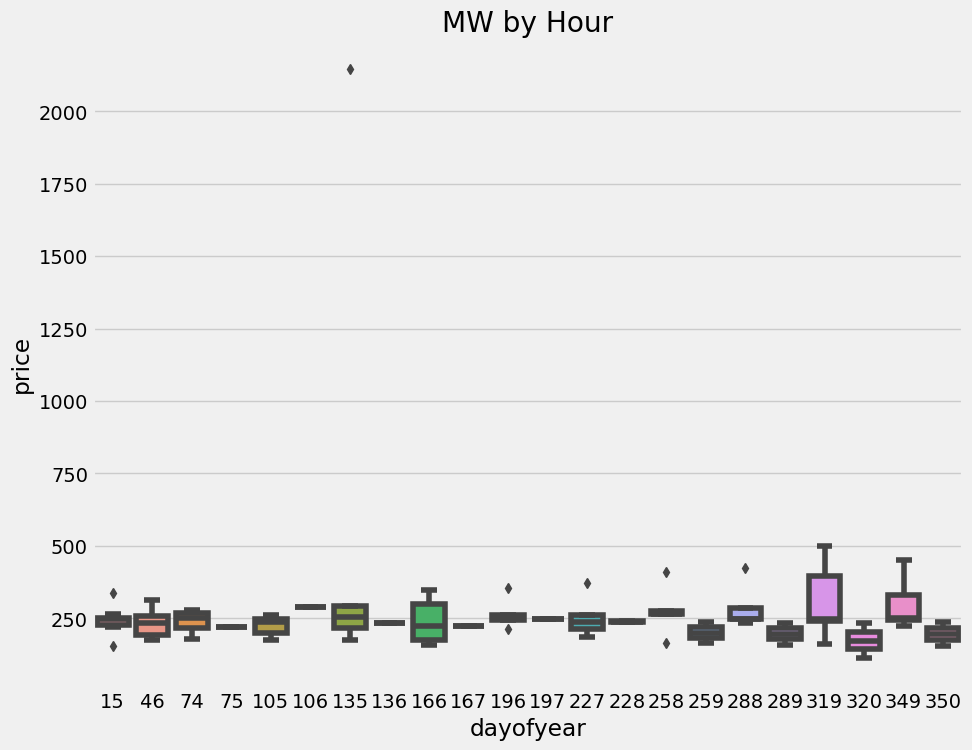

In [561]:
fig, ax = plt.subplots(figsize=(10, 8))
sns.boxplot(data=df, x='dayofyear', y='price')
ax.set_title('MW by Hour')
plt.show()

In [563]:
train = create_features(train)
test = create_features(test)

FEATURES = ['quarter', 'month', 'year', 'dayofyear', 'dayofmonth', 'weekofyear']
TARGET = 'price'

X_train = train[FEATURES]
y_train = train[TARGET]

X_test = test[FEATURES]
y_test = test[TARGET]

In [564]:
reg = xgb.XGBRegressor( booster='gbtree',    
                        )
reg.fit(X_train, y_train,
        eval_set=[(X_train, y_train), (X_test, y_test)],
        verbose=100)

[0]	validation_0-rmse:197.38805	validation_1-rmse:135.58952
[99]	validation_0-rmse:0.03131	validation_1-rmse:595.68111


XGBRegressor(base_score=None, booster='gbtree', callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

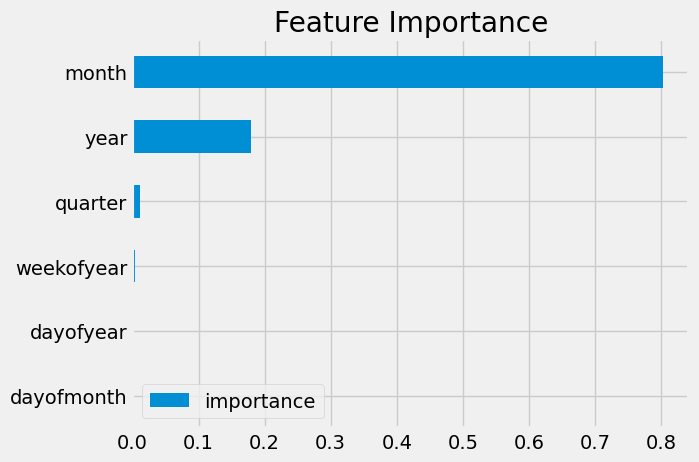

In [565]:
fi = pd.DataFrame(data=reg.feature_importances_,
             index=reg.feature_names_in_,
             columns=['importance'])
fi.sort_values('importance').plot(kind='barh', title='Feature Importance')
plt.show()

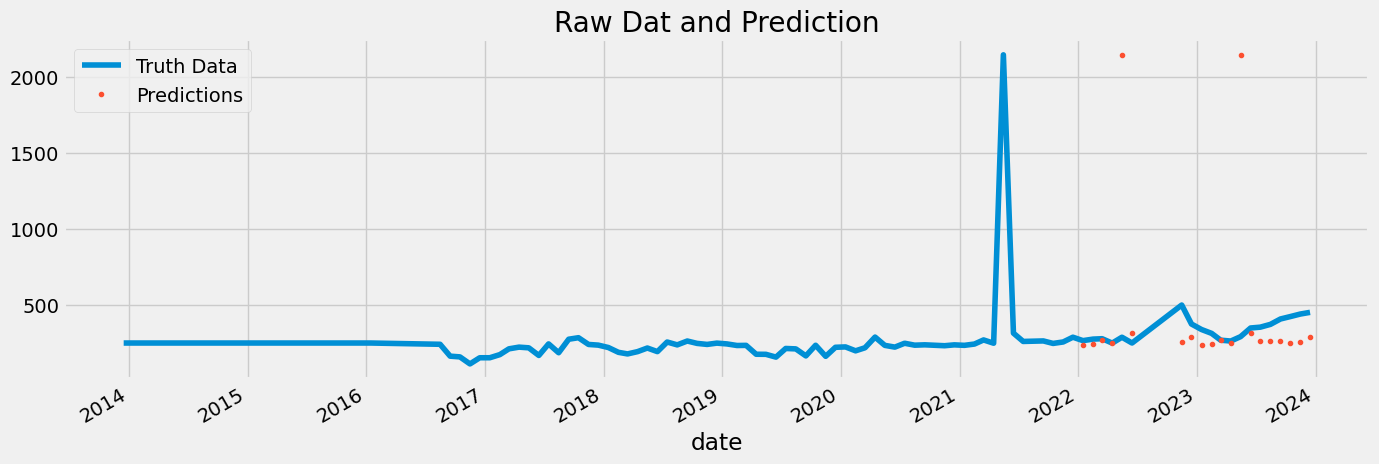

In [566]:
test['prediction'] = reg.predict(X_test)
df = df.merge(test[['prediction']], how='left', left_index=True, right_index=True)
ax = df[['price']].plot(figsize=(15, 5))
df['prediction'].plot(ax=ax, style='.')
plt.legend(['Truth Data', 'Predictions'])
ax.set_title('Raw Dat and Prediction')
plt.show()

In [567]:
score = np.sqrt(mean_squared_error(test['price'], test['prediction']))
print(f'RMSE Score on Test set: {score:0.2f}')

RMSE Score on Test set: 595.68


In [570]:
import pickle
with open('xgboost_model.pkl', 'wb') as f:
    pickle.dump(reg, f)

print("Model saved as 'xgboost_model.pkl'")

Model saved as 'xgboost_model.pkl'
